In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
data = pd.read_csv('nswretail.csv', index_col='Month', parse_dates=True, dayfirst=True)
data.tail()

,Turnover
Month,
2017-02-01,7298.9
2017-03-01,8085.8
2017-04-01,7883.7
2017-05-01,8132.0
2017-06-01,8130.1


In [4]:
y = data['Turnover'].copy()
y.index = y.index.to_period(freq='M')

ts = data['Turnover']

In [5]:
data.describe().round(2)

,Turnover
count,138.00
mean,6611.42
std,1168.73
min,4496.90
25%,5769.78
50%,6347.20
75%,7450.70
max,10783.10


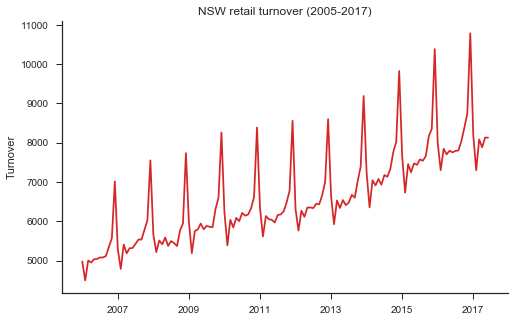

In [6]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('NSW retail turnover (2005-2017)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

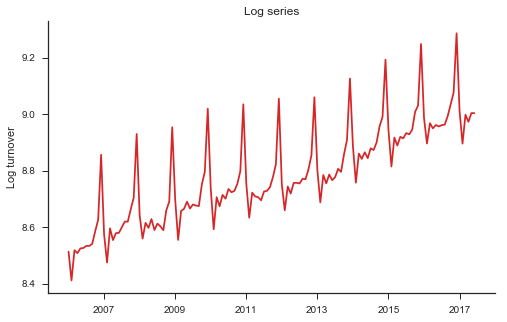

In [7]:
fig, ax= plt.subplots(figsize=(8,5))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log turnover')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

In [10]:
import forecast
ts=np.log(y) # log series for the log-additive model

validation=y['2012-01':].index
start = y.index.get_loc('2012-01') 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    resid = (ts.iloc[:i]-model.smooth())[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [17]:
import holtwinters as hw

ModuleNotFoundError: No module named 'holtwinters'

6414.35427202792
5543.15718053928
6068.570931800092
6083.821585282168
6305.969002243882
6177.831590692348
6422.471367208543
6449.387761416969
6377.49986429834
6765.583744796731
7071.929199599048
8885.134873937523
6633.110949264931
5693.069903304414
6330.78581720719
6257.035948076635
6442.726744333572
6381.371284168938
6586.1501937273015
6534.307024262301
6551.192093462388
6920.065576306255
7254.099462711375
9295.688631728555
6976.766608259193
6217.696563552143
6858.0060539708975
6706.487427383554
6953.234073740013
6957.071036375844
7054.913537037594
7114.004443754632
7196.741339353652
7442.654531628704
7968.432332144161
10095.484242832043
7663.79623033041
6739.352713644082
7344.521775524322
7133.925862422304
7366.978878764712
7272.150018227333
7410.79724485579
7617.157449296435
7577.10521243264
7932.790063470391
8336.620029585145
10492.297062617961
8090.490763224475
7121.5158955932
7788.984621545905
7695.308923085132
7838.186907045023
7712.178633906326
7841.996367789326
7891.8916648963

In [12]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,385.73,21.12
Additive,146.48,17.78
Multiplicative,134.39,10.07
Log additive,129.95,10.75
